article being followed: https://levelup.gitconnected.com/building-a-million-parameter-llm-from-scratch-using-python-f612398f06c2

## Importing libraries

In [1]:
import os
try:
    # Importing important functions
    # PyTorch
    import torch

    # Neural network modules and functions
    from torch import nn
    from torch.nn import functional as F

    # Numpy for numerical operations
    import numpy as np

    # Plotting loss etc.
    from matplotlib import pyplot as plt
        
    # Time
    import time

    # pandas for data manipulation
    import pandas as pd

    # urllib for handling URL requests (Downloding Dataset)
    import urllib.request

    # Progress bar
    from tqdm import tqdm
except AttributeError:
    %pip install torch numpy time pandas matplotlib urllib3 tqdm
    # Importing important functions
    # PyTorch
    import torch

    # Neural network modules and functions
    from torch import nn
    from torch.nn import functional as F

    # Numpy for numerical operations
    import numpy as np

    # Plotting loss etc.
    from matplotlib import pyplot as plt
        
    # Time
    import time

    # pandas for data manipulation
    import pandas as pd

    # urllib for handling URL requests (Downloding Dataset)
    import urllib.request


## Hyper Parameters

In [2]:
# hyper parameter dict
MASTER_CONFIG = {
    'batch_size' : 16,       #Number of batches to be processed at each random split
    'context_window' : 8,  # Number of characters in each (x) and target(y)
    'vocab_size' : 65,      # we have total 65 characters so vocab size is 65
    'd_model' : 128,        # total hidden parameters per layer
    'epochs' : 3000,        # total runs to train model
    'log_interval' : 10,    # after how many turns do i want to log
}

## Downloading Data

In [3]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x741fb999e810>)

# playing with data

In [4]:
# Read all the content of the dataset
lines = open("tinyshakespeare.txt","r").read()

# create sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display first 10 characters
print(f"printing first 10 char: {vocab[:10]}")

# Display total char in our dataset
print(f"printing total char: {len(vocab)}")

printing first 10 char: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
printing total char: 65


## mapping

In [5]:
#Mapping integers to characters (itos)
itos = {i:ch for i,ch in enumerate(vocab)}

#Mapping characters to integers (stoi)
stoi = {ch:i for i,ch in enumerate(vocab)}

# Display itos and stoi
print(itos)
print("\n")
print(stoi)

{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i', 48: 'j', 49: 'k', 50: 'l', 51: 'm', 52: 'n', 53: 'o', 54: 'p', 55: 'q', 56: 'r', 57: 's', 58: 't', 59: 'u', 60: 'v', 61: 'w', 62: 'x', 63: 'y', 64: 'z'}


{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 4

## Encoding

In [6]:
# Encode function: Converts a string to a list of int using stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of int to str using itos
def decode(lst):
    return "".join([itos[i] for i in lst])

# Example Encode string "hello"
print(encode("hello"))

# Example Decode list of int from encode
print(decode(encode("hello")))

[46, 43, 50, 50, 53]
hello


we got same result which is good

## Turning our dataset to tensor

In [7]:
# Convert dataset into torch tensor
dataset = torch.tensor(encode(lines), dtype= torch.int8) #text is UTF-8

# Display shape of resulting tensor
print(dataset.shape)

torch.Size([1115394])


## Splitting dataset to train and test set

In [8]:
# Function to get batches for training, validation or testing
def get_batches(data, split, batch_size, context_window):
    # Split dataset into training, validation and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)) : int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == "val":
        batch_data = val
    if split == "test":
        batch_data = test

    # Pick random starting point within data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

### Example

In [9]:
# Obtain batches for training using batch size and context window
xs, ys = get_batches(dataset, "train", MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode sequences to obtain text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist()))for i in range(len(xs))]

# Print random samples
print(decoded_samples)
print(f"length of batchsize = length of list: {len(decoded_samples)}")
print(f"length of batchsize = length of each string: {len(decoded_samples[0][0])}")

[(' farewel', 'farewell'), ('nd most ', 'd most a'), ('it: whis', 't: whist'), ('nodding ', 'odding o'), (' be the ', 'be the p'), ('cares, d', 'ares, di'), ('IUS:\nSir', 'US:\nSir,'), ("thus 'tw", "hus 'twi"), (" banish'", "banish'd"), ('king\nWhe', 'ing\nWher'), ('h now th', ' now the'), ('The pric', 'he price'), ('and towa', 'nd towar'), ('es, that', 's, that '), ('d rights', ' rights '), ('pple kne', 'ple knee')]
length of batchsize = length of list: 16
length of batchsize = length of each string: 8


# Setting up loss and evaluation function

In [10]:
@torch.no_grad() # Never use gradient for this func
def evaluate_loss(model, config = MASTER_CONFIG):
    out = {} # Evaluation result
    model.eval() # Set model to evaluation mode

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        losses = [] # individual loss

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, "train", MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

            # Perform model inference and calculate loss
            _, loss = model(xb, yb)

            # Append losss to list
            losses.append(loss.item())
        
        # Calculate mean loss for split and store it in out dict
        out[split] = np.mean(losses)
    
    # Set model to training mode again
    model.train()

    return out

# Base Neural Network Model

It's time my friends. we are going to make our own llm now

In [11]:
class SimpleModel(nn.Module):
    def __init__(self, config = MASTER_CONFIG):
        super().__init__()   # Initiate nn.Module class
        self.config = config # Setting up config

        # Embedding layer to convert char indices to vectors
        self.embedding = nn.Embedding(config["vocab_size"], config["d_model"])

        # Linear layers for modeling relationships between features
        # (to be update with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(in_features=config['d_model'], out_features=config['d_model']),
            nn.ReLU(), #will replace later
            nn.Linear(in_features=config['d_model'], out_features=config['vocab_size']),
        )

        # Print total num of model parameters
        print(f"Model parameters: {sum([m.numel() for m in self.parameters()])}")

    # Forward pass function
    def forward(self, idx, targets = None): # idx is input
        # Embedding layer converts character to indices to vectors
        x = self.embedding(idx)

        # Lienar layers
        a = self.linear(x)

        # Apply softmax to obtain probability dist
        logits = F.softmax(a,dim=-1)

        # If targets are provided, calculate and return cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy cal
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            # return logits, loss # remove softmax
            return a, loss
        
        #If targets are not provided, return logits
        else:
            # return logits # remove softmax
            return a

# trying out new model

In [12]:
model = SimpleModel(MASTER_CONFIG)
model

Model parameters: 33217


SimpleModel(
  (embedding): Embedding(65, 128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=65, bias=True)
  )
)

In [13]:
# # Obtain batches for training using specified batch size and context window
# xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# # Calculate logits and loss using model
# logits, loss = model(xs,ys)

In [14]:
# print(f'total loss is: {loss}')
# print(f'logits: {logits}')

# Training model

In [15]:
# Define optimizer for the model
optimizer = torch.optim.Adam(
    model.parameters(),   # Pass model parameters to optimizer
    lr = 0.0001
)

In [16]:
# Train Function
def train(model, optimizer, scheduler = None, config = MASTER_CONFIG, print_logs = False):
    losses = []

    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in tqdm(range(config['epochs'])):
        # Zero grad
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through model and calculate logits and loss
        logits, loss = model(xs, targets = ys)

        # Backward propagation and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust learning rate
        if scheduler:
            scheduler.step()
        
        # Log progress after every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store validation loss
            losses += [x]

            # Print progress logs
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            
            # Reset timer
            start_time = time.time()

            # Print learning rate if scheduler is provided
            if scheduler:
                print(f"lr: {scheduler.get_lr()}")

    # Print final validation loss
    print(f"Validation loss: {losses[-1]['val']}")

    # Plot training and validation loss curves
    return pd.DataFrame(losses).plot()

### execution time

100%|██████████| 3000/3000 [00:55<00:00, 54.35it/s]


Validation loss: 3.9481114864349367


<Axes: >

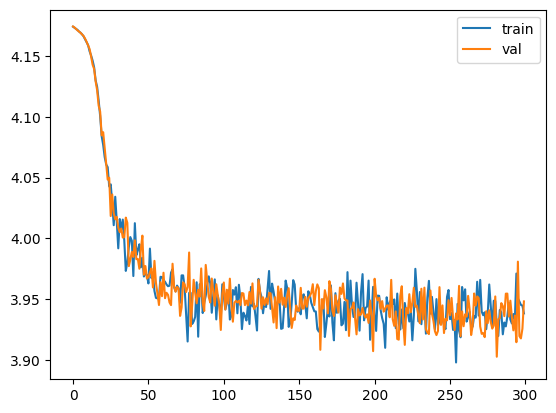

In [17]:
train(model, optimizer)

In [18]:
def generate(model, config=MASTER_CONFIG, max_new_tokens = 30):
    idx = torch.zeros(5,1).long()
    for _ in range(max_new_tokens):
        #call model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[:,-1,:] #all batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)
        idx_next = torch.multinomial(
            p, num_samples = 1
        ) # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim = -1) # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n']